
## Exp_1_compare_CBR_BB
Compare CBR Systems' performance with Black-box models

Experiments:

    1- Performance evaluation of black-box model with raw data  
    
    2- Performance evaluation of black-box model with over-sampled data 
    
    3- Performance evaluation of CBR system with raw data 
    
    4- Performance evaluation of CBR system with over-sampled data


In [1]:
#!pip install shap

In [2]:
# import required packages
import pandas as pd
import numpy as np

import shap
import joblib
import dice_ml

import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, plot_confusion_matrix

from pandas import json_normalize
import warnings
import requests
from requests import get
import random

from mycbr_py_api import MyCBRRestApi as mycbr

In [3]:
random_state = 60#random.randint(0, 100)
print('seed', random_state)
warnings.filterwarnings("ignore")

seed 60


#### Data preprocessing for experiments

In [4]:
# Read provided data set
df = pd.read_csv("./data/Dataset_MO_ENG.csv")

# Map classes accordingly
dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2} 
df['Target'] = df['Target'].map(dic)

# Eliminating physical-related questions
df = df.drop(df.columns[102:-1], axis=1)  

In [5]:
# Identifying target feature and other features
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]

# Rename the feature names to make it easier
X.columns = ['t' + str(i) for i in range(len(X.columns.to_list()))]
X.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t92,t93,t94,t95,t96,t97,t98,t99,t100,t101
0,1,1,0,1,0,1,1,1,0,0,...,0,1,1,0,0,1,0,1,0,1
1,1,0,1,1,0,1,1,1,0,0,...,0,0,1,0,0,1,0,1,1,0
2,0,0,0,0,1,1,1,0,0,1,...,0,0,1,0,0,1,0,1,0,1
3,0,0,0,1,0,1,1,1,1,0,...,0,0,1,0,1,1,0,1,0,1
4,1,1,0,1,0,1,0,1,1,1,...,0,0,1,0,0,1,0,1,0,0


In [6]:
# Raw split of dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)  

train = X_train.join(y_train)
test = X_test.join(y_test)

# Raw training data
train.to_csv('./data/train.csv',index=False) 
# Raw testing data
test.to_csv('./data/test.csv',index=False)


# Over-sampling the train set 
oversample = SMOTE(random_state=random_state,k_neighbors=5)
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
train_os = X_train_os.join(y_train_os)

# Over-sampled train set
train_os.to_csv('./data/train_oversampled.csv',index=False)

In [7]:
print(y_train.value_counts())
print(y_test.value_counts())

0    33
1    30
2    20
Name: Target, dtype: int64
2    10
0     6
1     5
Name: Target, dtype: int64


### 1 & 2 - Performance evaluation of black-box model with raw  and over-sampled data 


In [8]:
# Training models

# Train a MLP model with raw data set (mlp)
mlp=MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=1, 
                learning_rate='constant', learning_rate_init=0.0001, max_iter=100000, random_state=77)
mlp.fit(X_train, y_train)


# Train a MLP model with oversampled data set (mlp_os)
mlp_os=MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=1, 
                learning_rate='constant', learning_rate_init=0.0001, max_iter=100000, random_state=77)
mlp_os.fit(X_train_os, y_train_os)


# Save created models
joblib.dump(mlp,"./model/MLP.pkl")
joblib.dump(mlp_os,"./model/MLP_oversampled.pkl")

['./model/MLP_oversampled.pkl']

              precision    recall  f1-score   support

           0       0.27      0.67      0.38         6
           1       0.20      0.20      0.20         5
           2       0.00      0.00      0.00        10

    accuracy                           0.24        21
   macro avg       0.16      0.29      0.19        21
weighted avg       0.12      0.24      0.16        21



<AxesSubplot:>

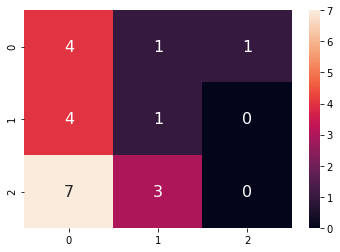

In [9]:
# Evaluation of Black-Box models

# test results for 'mlp' 
raw_model_results = mlp.predict(X_test)

print(classification_report(y_test, raw_model_results))

sns.heatmap(confusion_matrix(y_test, raw_model_results), annot=True, annot_kws={"size": 16})

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.43      0.60      0.50         5
           2       0.83      0.50      0.62        10

    accuracy                           0.57        21
   macro avg       0.59      0.59      0.57        21
weighted avg       0.64      0.57      0.58        21



<AxesSubplot:>

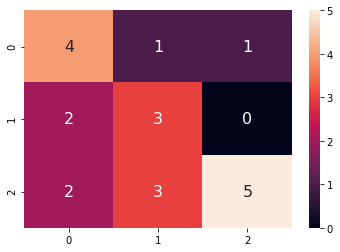

In [10]:
# Evaluation of Black-Box models

# test results for 'mlp_os' 
os_model_results = mlp_os.predict(X_test)

print(classification_report(y_test, os_model_results))

sns.heatmap(confusion_matrix(y_test, os_model_results), annot=True, annot_kws={"size": 16})

##### CBR setup for experiment 3 and 4

In [11]:
# API connection

server = 'localhost'
#server = 'user@hv-6066.idi.ntnu.no'

port = '8080'
base_url = 'http://' + server + ':' + port + '/'

headers = {'Content-type':'application/json'}

obj = mycbr(base_url)

In [12]:
# Variables that are related to current CBR project

# To list all concept names in the project uncomment the following line
# print(obj.getAllConcepts())

concept = 'case' 

In [13]:
# Deletes all cases from specified concept 
def delete_instances_from_concept(c):
    response = requests.delete('http://localhost:8080/concepts/'+c+'/cases')
    print("cases deleted from " + c + ": " + str(response.ok))
    
# Adds a new casebase 
def put_new_cb(newCbName):
    requests.put(base_url + 'casebases/' + newCbName)
    
# Returns casebase list
def get_casebases():
    raw = pd.DataFrame(requests.get(base_url + 'casebases/').json())
    casebases = pd.DataFrame.from_records(raw).values.tolist()
    return casebases

# add cases to casebase
def add_rows_as_cases(x, c, cb):
    case_id = 'case_' + str(x['index'])
    x = x.drop(['Target', 'index'])
    requests.put(base_url + 'concepts/' + c + '/casebases/' + cb +'/cases/' + case_id, data = str(x.to_json()), headers=headers)

# add cases to casebase from dataframe
def add_cases_from_df(df, c, cb):  
    tmp = df.copy(deep=True)
    tmp.reset_index(inplace=True)
    tmp.apply(add_rows_as_cases, args=(c, cb), axis=1)
    
# Rename indices of shap values (like 't0, t1')    
def rename_indices(idx):
    indx = []
    for i in range(len(idx)-1,-1,-1):
        indx.append('t'+str(idx[i]))
    return indx

# Add new amalgamation function
def newAmalgamationFunc(c, amalFuncID, amalFuncType, json):
    return requests.put(base_url + 'concepts/' + c + '/amalgamationFunctions?amalgamationFunctionID=' + amalFuncID + '&amalgamationFunctionType=' + amalFuncType + '&attributeWeightsJSON=' + json)

# Retrieves similar cases from given casebase
def query_cbr_system(concept, casebase, amalgamationFct, queryJSON, k=-1):
    raw = requests.post(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/amalgamationFunctions/' + amalgamationFct +'/retrievalByMultipleAttributes?k='+ str(k), 
                        data=str(queryJSON),
                        headers = headers)
    results = pd.DataFrame.from_dict(raw.json())
    results = results.apply(pd.to_numeric, errors='coerce').fillna(results).sort_values(by='similarity', ascending=False)
    return results[['caseID', 'similarity']]


# Returns a dataframe of similar cases from all casebases
def query_all_cbr_systems(concept, query, k):
    class_0_cbr_results = query_cbr_system(concept, 'cb_class0', 'amal_func_class0', query.to_json(), k)
    if 1 in class_0_cbr_results.similarity.values:
        class_0_cbr_results = query_cbr_system(concept, 'cb_class0', 'amal_func_class0', query.to_json(), k+1)    
        class_0_cbr_results = class_0_cbr_results[1:].reset_index(drop=True)
    class_0_cbr_results.columns = ['caseID_c0', 'similarity_c0']
    
    class_1_cbr_results = query_cbr_system(concept, 'cb_class1', 'amal_func_class1', query.to_json(), k)
    if 1 in class_1_cbr_results.similarity.values:
        class_1_cbr_results = query_cbr_system(concept, 'cb_class1', 'amal_func_class1', query.to_json(), k+1)    
        class_1_cbr_results = class_1_cbr_results[1:].reset_index(drop=True)
    class_1_cbr_results.columns = ['caseID_c1', 'similarity_c1']
    
    class_2_cbr_results = query_cbr_system(concept, 'cb_class2', 'amal_func_class2', query.to_json(), k)
    if 1 in class_2_cbr_results.similarity.values:
        class_2_cbr_results = query_cbr_system(concept, 'cb_class2', 'amal_func_class2', query.to_json(), k+1)    
        class_2_cbr_results = class_2_cbr_results[1:].reset_index(drop=True)
    class_2_cbr_results.columns = ['caseID_c2', 'similarity_c2']
    
    return pd.concat([class_0_cbr_results, class_1_cbr_results, class_2_cbr_results], axis=1)

# Returns class information of most similar case 
def get_class_from_cbr_results(x):
    classid = 5
    class_list = [x.similarity_c0, x.similarity_c1, x.similarity_c2]
    classid =class_list.index(max(class_list))
    return classid

### 3- Performance evaluation of CBR system with raw data 

#### Creating the CBR system with raw training data 

In [14]:
# Delete all cases
delete_instances_from_concept(concept)

print('Casebase names: ', get_casebases())

# Please uncomment following 3 lines if you don't see 'cb_class0', 'cb_class1', and 'cb_class2' in the list
# put_new_cb('cb_class0')
# put_new_cb('cb_class1')
# put_new_cb('cb_class2')

cases deleted from case: True
Casebase names:  [['cb_class1'], ['cb_class0'], ['cb_class2']]


In [15]:
# Group test samples up to classes
train_class0 = train.loc[train.Target == 0]
train_class1 = train.loc[train.Target == 1]
train_class2 = train.loc[train.Target == 2]

# Adding cases to respective casebases
add_cases_from_df(train_class0, concept, 'cb_class0')    
add_cases_from_df(train_class1, concept, 'cb_class1')    
add_cases_from_df(train_class2, concept, 'cb_class2')    

In [16]:
# Viewing the cases in a given casebase
obj.getAllCasesFromCaseBase(concept, 'cb_class0').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class1').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class2').head()

,similarity,caseID,Matched,t0,t1,t10,t100,t101,t11,t12,...,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99
0,1.0,case_36,NaN,0,0,0,1,1,0,1,...,0,0,0,0,1,0,0,1,0,1
1,1.0,case_15,NaN,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
2,1.0,case_78,NaN,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,1
3,1.0,case_35,NaN,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,1
4,1.0,case_57,NaN,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1


##### Calculting shap values for each class to create amalgamation functions

  0%|          | 0/83 [00:00<?, ?it/s]

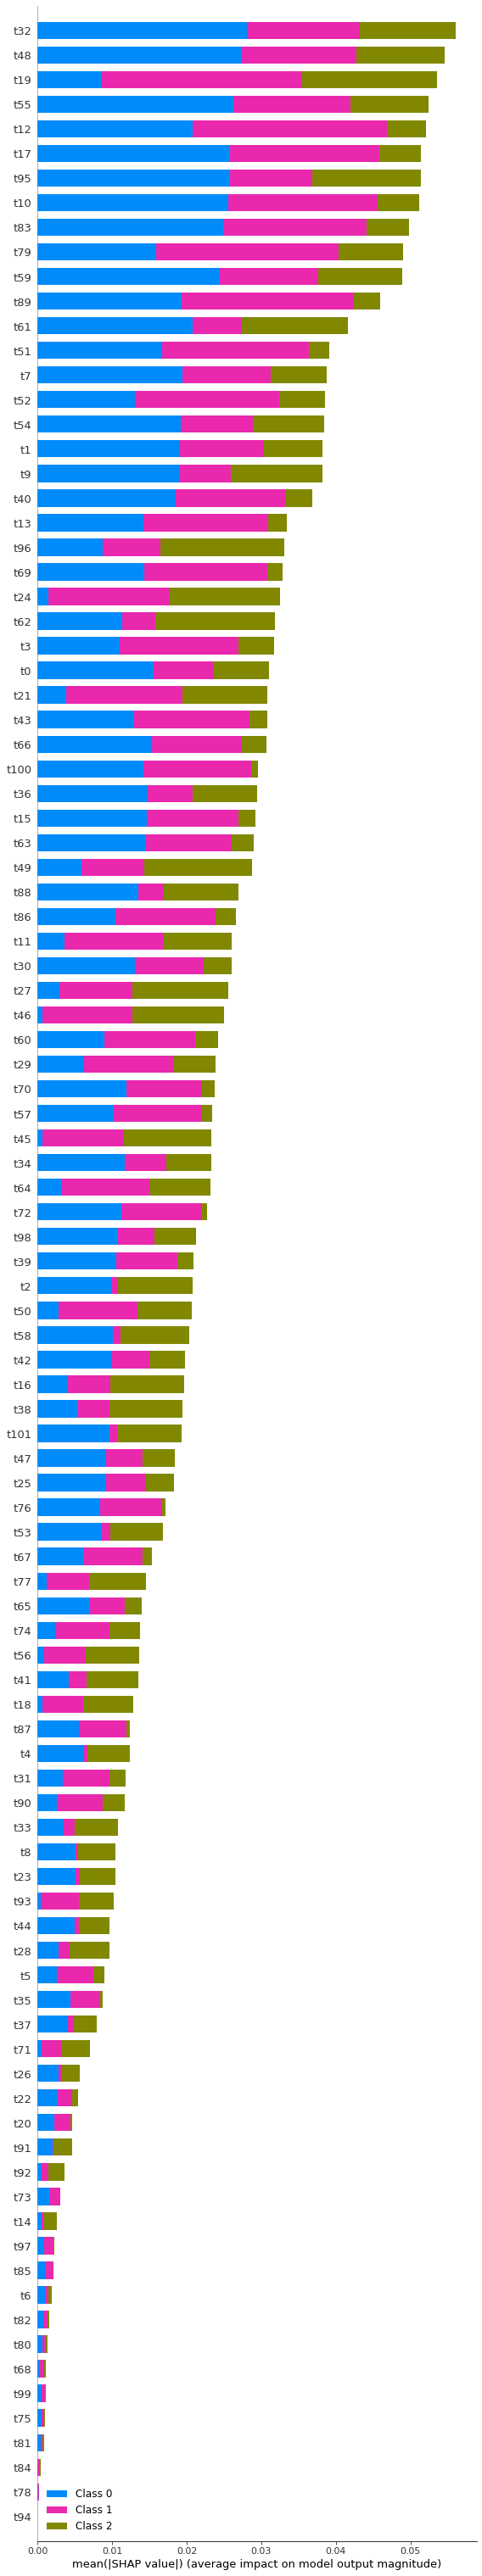

In [17]:
# Create shap kernel explainer using model and training data
explainer = shap.KernelExplainer(mlp.predict_proba, X_train)

# Shap values calculated for test data by explainer
shap_values = explainer.shap_values(X_train)

# Bar plot of calculated shap values (Each color implies a class)
shap.summary_plot(shap_values, X_train, plot_type="bar" ,max_display=102)

In [18]:
# Shap values for Class0
c0 = np.mean(np.abs(shap_values[0]), axis=0)
# sort indices
idx_c0 =np.argsort(c0)
# sort shap values
c0.sort()
sorted_mean0 = c0[::-1] 
# rename incdices
indx_0 = rename_indices(idx_c0)
shap_c0 = pd.DataFrame(sorted_mean0, index = indx_0, columns =['shap'])



# Shap values for Class1
c1 = np.mean(np.abs(shap_values[1]), axis=0)
# sort indices
idx_c1 =np.argsort(c1)
# sort shap values
c1.sort()
sorted_mean1 = c1[::-1] 
# rename incdices
indx_1 = rename_indices(idx_c1)
shap_c1 = pd.DataFrame(sorted_mean1, index = indx_1, columns =['shap'])


# Shap values for Class2
c2 = np.mean(np.abs(shap_values[2]), axis=0)
# sort indices
idx_c2 =np.argsort(c2)
# sort shap values
c2.sort()
sorted_mean2 = c2[::-1] 
# rename incdices
indx_2 = rename_indices(idx_c2)
shap_c2 = pd.DataFrame(sorted_mean2, index = indx_2, columns =['shap'])

In [19]:
# Save shap values
shap_c0.to_csv('./shap_values/c0.csv')
shap_c1.to_csv('./shap_values/c1.csv')
shap_c2.to_csv('./shap_values/c2.csv')

In [20]:
# Cast shap values to string for creating json objects (for newAmalgamationFunc)
str_map0 = str(shap_c0.to_dict()['shap']).replace("'",'"')
str_map1 = str(shap_c1.to_dict()['shap']).replace("'",'"')
str_map2 = str(shap_c2.to_dict()['shap']).replace("'",'"')

In [21]:
# Set amalgamation functions for each casebase
newAmalgamationFunc('case','amal_func_class0', 'WEIGHTED_SUM', str_map0)
newAmalgamationFunc('case','amal_func_class1', 'WEIGHTED_SUM', str_map1)
newAmalgamationFunc('case','amal_func_class2', 'WEIGHTED_SUM', str_map2)

<Response [200]>

In [22]:
# Query test samples from CBR system and create a df to compare CBR results with ground truth
test_data = test.reset_index()
test_data.head()

test_df = pd.DataFrame()

for case_idx in range(len(test_data)):
    query_c = test_data.loc[case_idx]
    target = query_c.Target
    query_c = query_c.drop(labels=['Target']).drop(['index'])

    result_df = query_all_cbr_systems(concept,  query_c, k=1)
    result_df['Class'] = target
  
    test_df = test_df.append(result_df)

test_df['cbr_class'] = test_df.apply(get_class_from_cbr_results, axis=1)

              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.33      0.60      0.43         5
           2       0.62      0.50      0.56        10

    accuracy                           0.43        21
   macro avg       0.40      0.42      0.39        21
weighted avg       0.45      0.43      0.42        21



<AxesSubplot:>

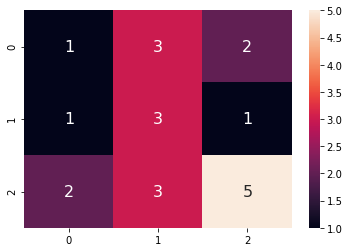

In [23]:
# Print evaluation results
y_pred = test_df['cbr_class']
y_true = test_df['Class']

print(classification_report(y_true, y_pred))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={"size": 16})

### 4- Performance evaluation of CBR system with over-sampled data


#### Creating the CBR system with over-sampled training data 

In [24]:
# Delete all cases
delete_instances_from_concept(concept)

print('Case base names: ', get_casebases())

# Please uncomment following 3 lines if you don't see 'cb_class0', 'cb_class1', and 'cb_class2' in the list
# put_new_cb('cb_class0')
# put_new_cb('cb_class1')
# put_new_cb('cb_class2')

cases deleted from case: True
Case base names:  [['cb_class1'], ['cb_class0'], ['cb_class2']]


In [25]:
# Group test samples up to classes
train_os_class0 = train_os.loc[train_os.Target == 0]
train_os_class1 = train_os.loc[train_os.Target == 1]
train_os_class2 = train_os.loc[train_os.Target == 2]

# Adding cases to respective casebases
add_cases_from_df(train_os_class0, concept, 'cb_class0')    
add_cases_from_df(train_os_class1, concept, 'cb_class1')    
add_cases_from_df(train_os_class2, concept, 'cb_class2')    

In [26]:
# Viewing the cases in a given casebase
obj.getAllCasesFromCaseBase(concept, 'cb_class0').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class1').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class2').head()

,similarity,caseID,Matched,t0,t1,t10,t100,t101,t11,t12,...,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99
0,1.0,case_36,NaN,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1
1,1.0,case_58,NaN,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
2,1.0,case_37,NaN,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1
3,1.0,case_34,NaN,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,1
4,1.0,case_78,NaN,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1


  0%|          | 0/99 [00:00<?, ?it/s]

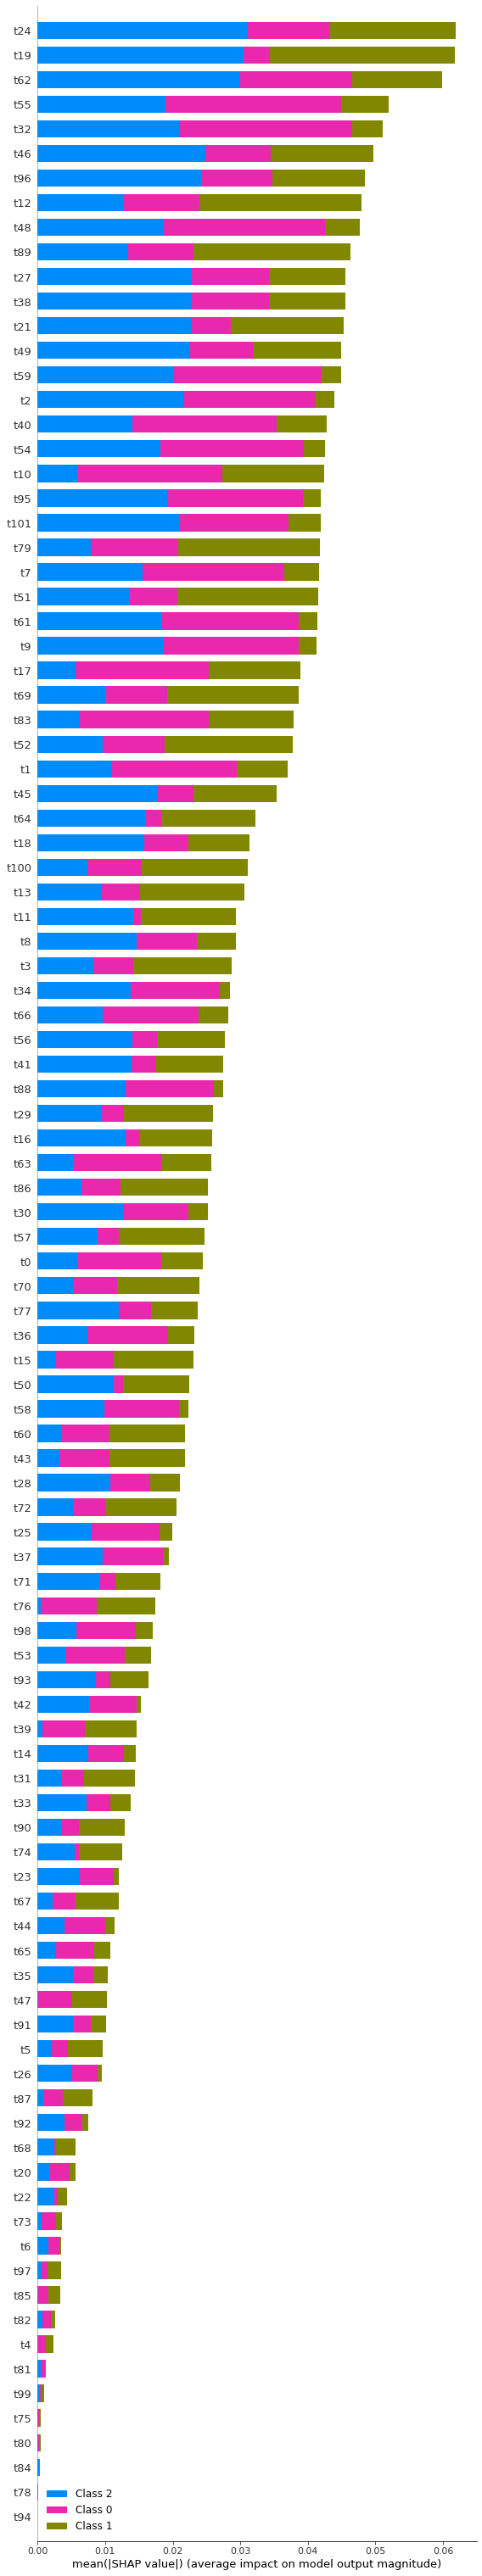

In [27]:
# Create shap kernel explainer using model and training data
explainer = shap.KernelExplainer(mlp_os.predict_proba, X_train_os)

# Shap values calculated for test data by explainer
shap_values = explainer.shap_values(X_train_os)

# Bar plot of calculated shap values (Each color implies a class)
shap.summary_plot(shap_values, X_train_os, plot_type="bar" ,max_display=102)

In [28]:
# Shap values for Class0
c0 = np.mean(np.abs(shap_values[0]), axis=0)
# sort indices
idx_c0 =np.argsort(c0)
# sort shap values
c0.sort()
sorted_mean0 = c0[::-1] 
# rename incdices
indx_0 = rename_indices(idx_c0)
shap_c0 = pd.DataFrame(sorted_mean0, index = indx_0, columns =['shap'])



# Shap values for Class1
c1 = np.mean(np.abs(shap_values[1]), axis=0)
# sort indices
idx_c1 =np.argsort(c1)
# sort shap values
c1.sort()
sorted_mean1 = c1[::-1] 
# rename incdices
indx_1 = rename_indices(idx_c1)
shap_c1 = pd.DataFrame(sorted_mean1, index = indx_1, columns =['shap'])


# Shap values for Class2
c2 = np.mean(np.abs(shap_values[2]), axis=0)
# sort indices
idx_c2 =np.argsort(c2)
# sort shap values
c2.sort()
sorted_mean2 = c2[::-1] 
# rename incdices
indx_2 = rename_indices(idx_c2)
shap_c2 = pd.DataFrame(sorted_mean2, index = indx_2, columns =['shap'])

In [29]:
# Save shap values
shap_c0.to_csv('./shap_values/c0_os.csv')
shap_c1.to_csv('./shap_values/c1_os.csv')
shap_c2.to_csv('./shap_values/c2_os.csv')

In [30]:
# Cast shap values to string for creating json objects (for newAmalgamationFunc)
str_map0 = str(shap_c0.to_dict()['shap']).replace("'",'"')
str_map1 = str(shap_c1.to_dict()['shap']).replace("'",'"')
str_map2 = str(shap_c2.to_dict()['shap']).replace("'",'"')

In [31]:
# Set amalgamation functions for each casebase
newAmalgamationFunc('case','amal_func_class0', 'WEIGHTED_SUM', str_map0)
newAmalgamationFunc('case','amal_func_class1', 'WEIGHTED_SUM', str_map1)
newAmalgamationFunc('case','amal_func_class2', 'WEIGHTED_SUM', str_map2)

<Response [200]>

In [32]:
# Query test samples from CBR system and create a df to compare CBR results with ground truth
test_data = test.reset_index()
test_data.head()

test_df = pd.DataFrame()

for case_idx in range(len(test_data)):
    query_c = test_data.loc[case_idx]
    target = query_c.Target
    query_c = query_c.drop(labels=['Target']).drop(['index'])

    result_df = query_all_cbr_systems(concept,  query_c, k=1)
    result_df['Class'] = target
  
    test_df = test_df.append(result_df)

test_df['cbr_class'] = test_df.apply(get_class_from_cbr_results, axis=1)

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         6
           1       0.27      0.60      0.37         5
           2       0.00      0.00      0.00        10

    accuracy                           0.29        21
   macro avg       0.20      0.37      0.26        21
weighted avg       0.16      0.29      0.20        21



<AxesSubplot:>

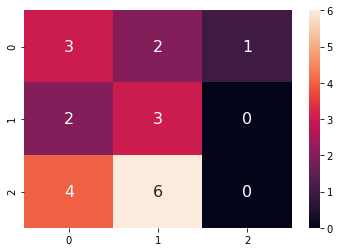

In [33]:
# Print evaluation results
y_pred = test_df['cbr_class']
y_true = test_df['Class']

print(classification_report(y_true, y_pred))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={"size": 16})